##1. Configurações

É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir. Se o resultado da execução da célula de código abaixo for "Not connected to a GPU", mude o ambiente. Acesse <code>Runtime &gt; Change runtime type</code> no menu para ativar um acelerador de GPU, depois execute novamente a célula de código.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 31 12:12:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<code>Runtime &gt; Change runtime type</code> no menu. Depois selecione "RAM alta" no menu suspenso "Características do ambiente de execução".

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#bibliotecas e módulos
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import tensorflow as tf
import time

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception

In [3]:
#caminhos, constantes e parâmetros
#data
DATASET = 'Caltech256' #'Caltech101', 'Caltech256', 'octimine'

#image
CH = 3 #color channels
IM_HEIGHT = 224
IM_WIDTH = 224
INTERPOLATION = 'bilinear'   #'bilinear', 'nearest', 'bicubic', 'area', 'lanczos3', 'lanczos5', 'gaussian' or 'mitchellcubic'

#
BATCH_SIZE = 128
SEED = 517

#algorithm
NEIGHBORS = 15

In [4]:
DATA_DIR = '/content/drive/My Drive/octimine/data/'
IM_DIR = '/content/drive/My Drive/octimine/' + DATASET


##2. Carregar Dados

In [5]:
#carregar imagens
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

dataset = tf.keras.utils.image_dataset_from_directory(
  IM_DIR,
  labels='inferred', #'inferred', None
  label_mode='categorical',  #'int', 'categorical', 'binary' or None
  class_names=None,
  color_mode='rgb',  #'grayscale', 'rgb' or 'rgba'
  batch_size=BATCH_SIZE,
  image_size=(IM_HEIGHT, IM_WIDTH),
  shuffle=False,
  seed=SEED,
  validation_split=None,
  subset=None,                #'training', 'validation' or 'both'
  interpolation=INTERPOLATION,
  follow_links=False,
  crop_to_aspect_ratio=False
)

Found 30607 files belonging to 257 classes.


In [ ]:
#lista e grava o nome de todas as classes em um arquivo pickle
class_names = dataset.class_names
pickle.dump(
    class_names,
    open(DATA_DIR + DATASET + '-classes.pickle', 'wb'))

In [ ]:
#lista e grava o endereço de todas as imagens em um arquivo pickle
path_list = dataset.file_paths
pickle.dump(
    path_list,
    open(DATA_DIR + DATASET + '-images.pickle', 'wb'))

In [6]:
#total de imagens no dataset
im_total = len(dataset.file_paths)
im_total

30607

In [7]:
#número de passos durante a extração de features
STEPS = int(math.ceil(im_total / BATCH_SIZE))
STEPS

240

##3. Manipular Dados

In [8]:
#data augmentation with horizontal flipping, rotation and zoom
augmentation_layer = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.25),
  ]
)

augmented_dataset = dataset.map(lambda x, y: (augmentation_layer(x), y))

augmented_dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 257), dtype=tf.float32, name=None))>

In [9]:
#rescale (normalize) dataset
rescale_layer = tf.keras.layers.Rescaling(1./255.) #entre [0, 1]
#rescale_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1) #entre [-1, 1]

rescaled_dataset = augmented_dataset.map(lambda x, y: (rescale_layer(x), y))
im_batch, labels_batch = next(iter(rescaled_dataset))

rescaled_dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 257), dtype=tf.float32, name=None))>

In [10]:
#configura dados para melhor desempenho
#https://www.tensorflow.org/tutorials/load_data/images#configure_the_dataset_for_performance

AUTOTUNE = tf.data.AUTOTUNE
#tuned_dataset = rescaled_dataset.cache().prefetch(buffer_size=AUTOTUNE)
tuned_dataset = dataset.prefetch(buffer_size=AUTOTUNE)

##4. Modelo

In [ ]:
#carrega modelo base pré-treinado
#https://keras.io/guides/transfer_learning/

'''
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(IM_WIDTH, IM_HEIGHT, CH),
                  pooling='max')

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
model = VGG19(weights='imagenet',
              include_top=False,
              input_shape=(IM_WIDTH, IM_HEIGHT, CH),
              pooling='max')

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
#congela modelo base pré-treinado
model.trainable = False

In [13]:
#extrai características (features)
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
#https://keras.io/api/models/model_training_apis/
#https://github.com/keras-team/keras/blob/v2.10.0/keras/engine/training.py#L2076
#link to solve the memory problem
#https://www.thekerneltrip.com/python/keras-memory-leak/

feature_list = []

feature_list = model.predict(
  tuned_dataset,
  batch_size=None,
  verbose='auto',
  steps=STEPS, #entender melhor influência desse atributo
  callbacks=None,
  max_queue_size=10,
  workers=1,
  use_multiprocessing=False
)

240/240 [==============================] - 2363s 10s/step


In [14]:
feature_list.shape

(30607, 512)

In [15]:
#grava lista de características no disco
pickle.dump(
    feature_list,
    open(DATA_DIR + DATASET + '-featuresVGG19001.pickle', 'wb'))

##5. Busca

In [16]:
cl_list   = pickle.load(open(DATA_DIR + DATASET + '-classes.pickle', 'rb'))
path_list = pickle.load(open(DATA_DIR + DATASET + '-images.pickle', 'rb'))
feat_list = pickle.load(open(DATA_DIR + DATASET + '-featuresVGG19001.pickle', 'rb'))

In [17]:
#treina algoritmo KNN
#https://scikit-learn.org/stable/modules/neighbors.html
KNN = NearestNeighbors(n_neighbors=NEIGHBORS,
                       algorithm='brute',
                       metric='euclidean').fit(feat_list) 

(-0.5, 259.5, 172.5, -0.5)

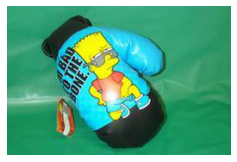

In [18]:
#query internal image
#find image index
#https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-list

#im_path = 'Faces/image_0658.jpg'
#im_idx = path_list.index(IM_DIR + im_path)
im_idx = 2456 #660

#good: 1658, 4456, 12000, 17351
#bad: 658, 2456, 11456, 20000, 27501
#strange: 9000
#compare: 1904 with 1905

#lista distâncias entre a query image e as n imagens similares
#lista índices das n imagens similares
distances, indices = KNN.kneighbors([feat_list[im_idx]])

#print query image
plt.figure(figsize=(4, 4))
plt.imshow(mpimg.imread(path_list[im_idx]), interpolation=INTERPOLATION)
plt.axis("off")

2.1579186e-05 /content/drive/My Drive/octimine/Caltech256/019.boxing-glove/019_0116.jpg 2456
719.3458 /content/drive/My Drive/octimine/Caltech256/249.yo-yo/249_0010.jpg 27936
725.7746 /content/drive/My Drive/octimine/Caltech256/014.blimp/014_0049.jpg 1885
732.94794 /content/drive/My Drive/octimine/Caltech256/193.soccer-ball/193_0161.jpg 22093
753.91394 /content/drive/My Drive/octimine/Caltech256/242.watermelon/242_0073.jpg 27357
756.04065 /content/drive/My Drive/octimine/Caltech256/205.superman/205_0012.jpg 23183
756.4426 /content/drive/My Drive/octimine/Caltech256/200.stained-glass/200_0018.jpg 22740
756.75397 /content/drive/My Drive/octimine/Caltech256/191.sneaker/191_0039.jpg 21748
757.8435 /content/drive/My Drive/octimine/Caltech256/019.boxing-glove/019_0074.jpg 2414
759.62225 /content/drive/My Drive/octimine/Caltech256/047.computer-mouse/047_0055.jpg 5362
760.4082 /content/drive/My Drive/octimine/Caltech256/124.killer-whale/124_0004.jpg 13525
761.4696 /content/drive/My Drive/octim

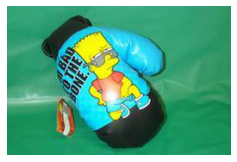

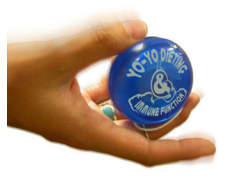

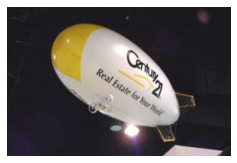

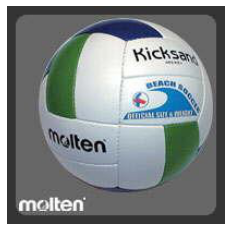

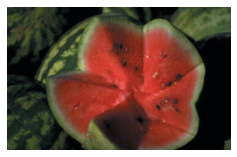

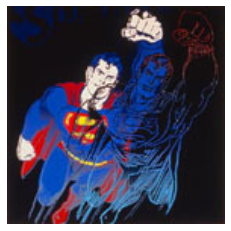

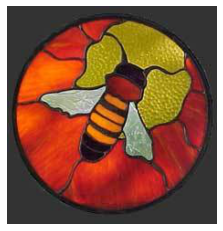

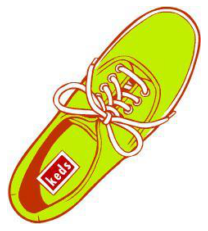

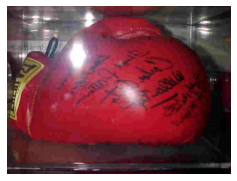

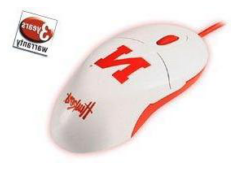

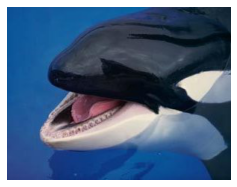

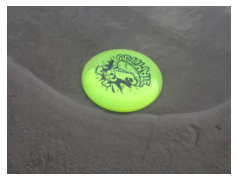

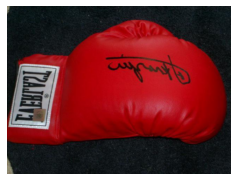

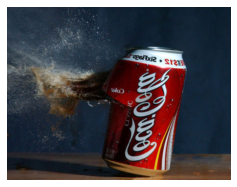

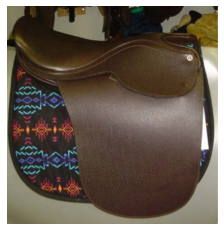

In [19]:
for i in range(NEIGHBORS):
  print(distances[0][i], path_list[indices[0][i]], indices[0][i])
  plt.figure(figsize=(4, 4))
  plt.imshow(mpimg.imread(path_list[indices[0][i]]), interpolation=INTERPOLATION)
  plt.axis("off")

In [ ]:
'''
#query external image
tf.keras.utils.load_img(
    path,
    color_mode="rgb", #"grayscale", "rgb", "rgba"
    target_size=None,
    interpolation="nearest",
    keep_aspect_ratio=False,
)

#Interpolation: "nearest", "bilinear", and "bicubic".
#If PIL version 1.1.3 or newer is installed, "lanczos" is also supported.
#If PIL version 3.4.0 or newer is installed, "box" and "hamming" are also supported.

In [ ]:
'''
#https://www.tensorflow.org/guide/data#consuming_sets_of_files
#lê arquivo e extrai CPC class

def process_path(file_path):
  label = tf.strings.split(file_path, os.sep)[-2]
  return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)